In [33]:
import torch
from torch import nn
from torch.utils.data import Dataset,random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [34]:
training_data=datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data=datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

validation_data, test_data = random_split(test_data, [5000, 5000])

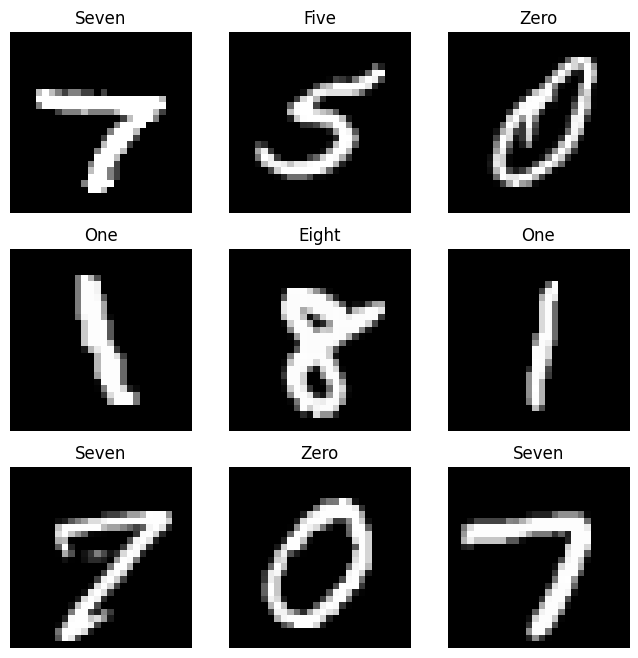

In [35]:
labels_map = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [36]:

input_size = 28
hidden_size = 256
num_layers = 2
num_classes = 10
sequence_length = 28

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) #Don't have to specify sequence length becuase it can work on variable sequence length
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #(num_layers, batch_size, hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #(num_layers, batch_size, hidden_size)
        # Forward propagate LSTM
        #Shape of x is (batch_size,sequence_length,input_size)
        out, (_,_c) = self.lstm(x, (h0,c0)) #Shape of out is (batch_size,sequence_length,hidden_size) & _ is previous hidden state and shape is (num_layers,hidden_size)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out
    
def train_loop(train_dataloader,val_dataloader,model,loss_fn,optimizer,batch_size,epoch):
    train_size=len(train_dataloader.dataset)
    num_batches=len(train_dataloader)
    loss_tot=0
    train_correct=0
    for batch,(X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model.train()
        pred=model(X.squeeze(1))
        loss=loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_tot+=loss.item()
        model.eval()
        pred=model(X.squeeze(1))
        train_correct_each = (pred.argmax(1) == y).type(torch.float).sum().item()
        train_acc=train_correct_each/(y.shape[0])
        train_correct+=train_correct_each
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"\rEpoch {epoch+1} : Training loss: {loss:>7f} - Training Accuracy: {train_acc:>7f}  [{current:>5d}/{train_size:>5d}]", end="")
    loss_avg=loss_tot/num_batches
    train_acc = train_correct/train_size
    val_loss = 0
    val_correct=0
    val_size=len(val_dataloader.dataset)
    model.eval()
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.squeeze(1))
            val_loss += loss_fn(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= len(val_dataloader)
    val_acc=val_correct/val_size
    writer.add_scalars('Training vs. Validation Loss',{ 'Training' : loss_avg, 'Validation' : val_loss },epoch +1)
    writer.add_scalars('Training vs. Validation Accuracy',{ 'Training' : train_acc, 'Validation' : val_acc },epoch +1)
    print(f"\rEpoch {epoch+1} : Training loss: {loss_avg:>7f} - Training Accuracy: {train_acc:>7f} - Validation loss: {val_loss:>7f} - Validation accuracy: {val_acc:>7f}")
    print(end='')
    return loss_avg, train_acc, val_loss, val_acc


def test_loop(dataloader,model,loss_fn):
    size=len(dataloader.dataset)
    model.eval()
    num_batches=len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X,y) in dataloader:
            X, y = X.to(device), y.to(device)
            pred=model(X.squeeze(1))
            test_loss+=loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc=correct/size
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=NeuralNetwork(input_size, hidden_size, num_layers, num_classes).to(device)

learning_rate = 1e-3
batch_size = 64
epochs = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader=DataLoader(training_data,batch_size,shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size, shuffle=True)
test_dataloader=DataLoader(test_data,batch_size,shuffle=True)

# summary(model, (28,28))

In [37]:
loss_history = {'train': [], 'val': []}
accuracy_history = {'train': [], 'val': []}

best_val_loss = float('inf')
patience = 3  # How many epochs to wait after last improvement
patience_counter = 0 
min_delta=0.001

for t in range(epochs):
    print(f"Epoch {t+1}",end=" ")
    train_loss, train_accuracy, val_loss, val_accuracy =train_loop(train_dataloader,validation_dataloader, model, loss_fn, optimizer,batch_size,t)
    # test_loop(test_dataloader, model, loss_fn)
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)
    accuracy_history['train'].append(train_accuracy)
    accuracy_history['val'].append(val_accuracy)

    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        patience_counter += 1 
    
    if patience_counter >= patience:
        print(f"\nStopping early at epoch {t+1} with restoring best weights")
        epochs=t+1
        break 
    
writer.flush()

Epoch 1 : Training loss: 0.221594 - Training Accuracy: 0.940617 - Validation loss: 0.070321 - Validation accuracy: 0.977600
Epoch 2 : Training loss: 0.064184 - Training Accuracy: 0.986950 - Validation loss: 0.066635 - Validation accuracy: 0.977400
Epoch 3 : Training loss: 0.045581 - Training Accuracy: 0.991167 - Validation loss: 0.040602 - Validation accuracy: 0.989000
Epoch 4 : Training loss: 0.036568 - Training Accuracy: 0.993700 - Validation loss: 0.034969 - Validation accuracy: 0.990600
Epoch 5 : Training loss: 0.028741 - Training Accuracy: 0.995533 - Validation loss: 0.048313 - Validation accuracy: 0.986200
Epoch 6 : Training loss: 0.026493 - Training Accuracy: 0.995600 - Validation loss: 0.042343 - Validation accuracy: 0.987600
Epoch 7 : Training loss: 0.019479 - Training Accuracy: 0.997267 - Validation loss: 0.034417 - Validation accuracy: 0.989000

Stopping early at epoch 7 with restoring best weights


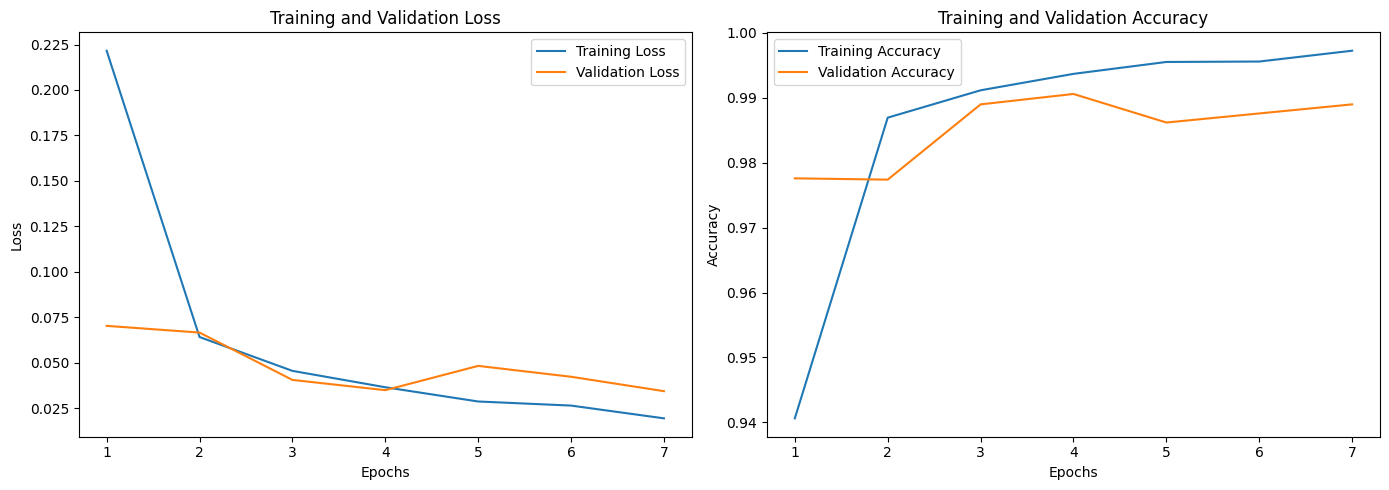

In [38]:
plt.figure(figsize=(14, 5))
eplist=[]
for i in range(epochs):
    eplist.append(i+1)
plt.subplot(1, 2, 1)
plt.plot(eplist, loss_history['train'], label='Training Loss')
plt.plot(eplist, loss_history['val'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eplist, accuracy_history['train'], label='Training Accuracy')
plt.plot(eplist, accuracy_history['val'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()